In [2]:
%load_ext autoreload
%autoreload 2

from typing import Optional, Union
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import sys 
import seaborn as sns

sys.path.append('../../src/modules')
import eumf_data, eumf_pipeline, eumf_eval
from eumf_data import Labeled

from sklearn import dummy, preprocessing, pipeline, compose, ensemble, model_selection, metrics, impute

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)



## Preparation

### Load Data

In [3]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]



10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions (1)

In [4]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

lags_default = [1, 2, 3, 4, 5, 6]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6],
    "gdp": [2, 3, 4, 5, 6],
    "unempl": [2, 3, 4, 5, 6],
}

### Optimum threshold

#### No autoregressive lags

In [6]:
### TRAINING

thresholds = [1.05, 1.1, 1.15, 1.20, 1.25, 1.3, 1.35, 1.4]
scores, dummy_scores = [], []




for thresh in thresholds:

    bins = [-np.inf, np.log(thresh), np.inf]
    classes = [0, 1]

    params = {}

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=["19", "gdp", "unempl"],
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)

    # stacked = stack_data(transformed)
    # data_cls = discretize_labels(stacked)

    train, test = eumf_pipeline.split_data(
        transformed, t_test_min="2014", t_test_max="2014"
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
    train_cls, test_cls = eumf_pipeline.discretize_labels(
        train_stacked, test_stacked, bins=bins, classes=classes
    )

    # train_stacked = stack_data(transformed)
    # train_cls = discretize_labels(train_stacked, bins=bins, classes=classes)

    tuner = eumf_pipeline.train_cls_model(
        train_cls, params=params, cv=cv_default, scoring="f1"
    )

    dummy_cls = dummy.DummyClassifier(strategy="stratified")

    scores.append(
        eumf_eval.score_cv(
            tuner.best_estimator_,
            train_cls,
            cv=cv_default,
            scoring=["precision", "recall", "f1"],
        )
    )

    dummy_scores.append(
        eumf_eval.score_cv(
            dummy_cls,
            train_cls,
            cv=cv_default,
            scoring=["precision", "recall", "f1"],
        )
    )


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages

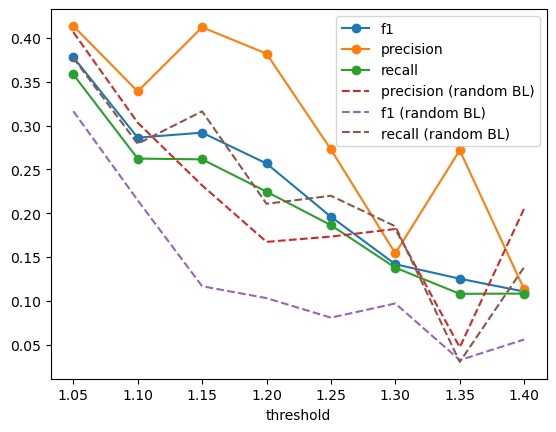

In [7]:
### PLOT

scores_df = (
    pd.concat([s.mean() for s in scores], axis=1)
    .transpose()
    .assign(threshold=thresholds)
)
dummy_scores_df = (
    pd.concat([s.mean() for s in dummy_scores], axis=1)
    .transpose()
    .assign(threshold=thresholds)
)
plt.plot(scores_df["threshold"], scores_df["test_f1"], "o-", label="f1")
plt.plot(scores_df["threshold"], scores_df["test_precision"], "o-", label="precision")
plt.plot(scores_df["threshold"], scores_df["test_recall"], "o-", label="recall")
plt.plot(dummy_scores_df["threshold"], dummy_scores_df["test_precision"], "--", label="precision (random BL)")
plt.plot(dummy_scores_df["threshold"], dummy_scores_df["test_f1"], "--", label="f1 (random BL)")
plt.plot(dummy_scores_df["threshold"], dummy_scores_df["test_recall"], "--", label="recall (random BL)")
plt.xlabel("threshold")
plt.legend()
plt.show()


#### With autoregressive lags

In [16]:
### TRAINING

thresholds = [1.05, 1.1, 1.15, 1.20, 1.25, 1.3, 1.35, 1.4]
scores, dummy_scores = [], []

for thresh in thresholds:

    bins = [-np.inf, np.log(thresh), np.inf]
    classes = [0, 1]

    params = {}

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=["19", "gdp", "unempl", "value"],
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)

    # stacked = stack_data(transformed)
    # data_cls = discretize_labels(stacked)

    train, test = eumf_pipeline.split_data(
        transformed, t_test_min="2019", t_test_max="2019"
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
    train_cls, test_cls = eumf_pipeline.discretize_labels(
        train_stacked, test_stacked, bins=bins, classes=classes
    )

    # train_stacked = stack_data(transformed)
    # train_cls = discretize_labels(train_stacked, bins=bins, classes=classes)

    tuner = eumf_pipeline.train_cls_model(
        train_cls, params=params, cv=cv_default, scoring="f1"
    )

    dummy_cls = dummy.DummyClassifier(strategy="stratified")

    scores.append(
        eumf_eval.score_cv(
            tuner.best_estimator_,
            train_cls,
            cv=cv_default,
            scoring=["precision", "recall", "f1"],
        )
    )

    dummy_scores.append(
        eumf_eval.score_cv(
            dummy_cls,
            train_cls,
            cv=cv_default,
            scoring=["precision", "recall", "f1"],
        )
    )


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages

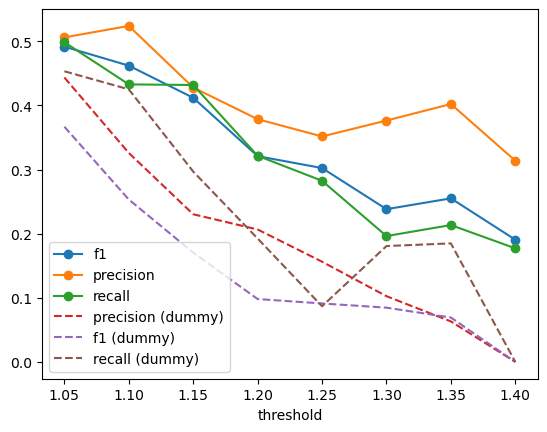

In [17]:
### PLOT

scores_df = (
    pd.concat([s.mean() for s in scores], axis=1)
    .transpose()
    .assign(threshold=thresholds)
)
dummy_scores_df = (
    pd.concat([s.mean() for s in dummy_scores], axis=1)
    .transpose()
    .assign(threshold=thresholds)
)
plt.plot(scores_df["threshold"], scores_df["test_f1"], "o-", label="f1")
plt.plot(scores_df["threshold"], scores_df["test_precision"], "o-", label="precision")
plt.plot(scores_df["threshold"], scores_df["test_recall"], "o-", label="recall")
plt.plot(dummy_scores_df["threshold"], dummy_scores_df["test_precision"], "--", label="precision (dummy)")
plt.plot(dummy_scores_df["threshold"], dummy_scores_df["test_f1"], "--", label="f1 (dummy)")
plt.plot(dummy_scores_df["threshold"], dummy_scores_df["test_recall"], "--", label="recall (dummy)")
plt.xlabel("threshold")
plt.legend()
plt.show()


### Common definitions (2)

In [38]:
SCORING_TWOCLS = [
    "roc_auc",
    "accuracy",
    "f1",
    "precision",
    "recall",
    "f1_macro",
]

metrics.make_scorer(metrics.recall_score, pos_label=1)
metrics.make_scorer(metrics.recall_score, pos_label=0)


SCORING_TWOCLS_COMP = {
    "neg_recall": metrics.make_scorer(metrics.recall_score, pos_label=0),
    "neg_precision": metrics.make_scorer(metrics.precision_score, pos_label=0),
    "neg_f1": metrics.make_scorer(metrics.f1_score, pos_label=0)
}
# note: f1 macro only for comparison

T_TEST_MIN_TWOCLS = "2019"
T_TEST_MAX_TWOCLS = "2019"

BINS_TWOCLS = [-np.inf, np.log(1.10), np.inf]


### "Best" configuration with different feature sets

In [39]:
### TRAINING

feature_combinations = [
    ["dummy"],
    ["19", "gdp", "unempl"],
    ["19"],
    ["gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
    ["value", "gdp", "unempl"],
]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_unstackeds, test_clss, train_clss = [], [], []

params = {}

for features in feature_combinations:

    if "dummy" in features:
        columns = ["value"]
    else:
        columns = features

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=columns,
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)

    # stacked = stack_data(transformed)
    # data_cls = discretize_labels(stacked)

    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN_TWOCLS, t_test_max=T_TEST_MAX_TWOCLS
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)
    train_cls, test_cls = eumf_pipeline.discretize_labels(
        train_stacked, test_stacked, bins=BINS_TWOCLS, classes=[0, 1]
    )

    train_clss.append(train_cls)
    train_unstackeds.append(train)
    test_clss.append(test_cls)

    # train_stacked = stack_data(transformed)
    # train_cls = discretize_labels(train_stacked, bins=bins, classes=classes)

    if "dummy" in features:
        tuners.append(None)
        estimator = dummy.DummyClassifier(strategy="most_frequent").fit(train_cls.x, train_cls.y)
    else:
        tuner = eumf_pipeline.train_cls_model(
            train_cls, params=params, cv=cv_default
        )
        tuners.append(tuner)
        estimator = tuner.best_estimator_
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(
        estimator, train_cls, cv=cv_default, scoring=SCORING_TWOCLS,
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(estimator, test_cls, scoring=SCORING_TWOCLS,)
    test_scores.append(test_score)


/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages

In [43]:
cv_scores[-1]

,fit_time,score_time,test_roc_auc,test_accuracy,test_f1,test_precision,test_recall,test_f1_macro
0,0.224,0.042,0.716,0.486,0.532,0.913,0.375,0.481
1,0.233,0.044,0.857,0.750,0.795,0.745,0.854,0.737
2,0.178,0.036,0.714,0.653,0.615,0.541,0.714,0.649
3,0.158,0.034,0.804,0.750,0.640,0.593,0.696,0.724
4,0.154,0.032,0.776,0.833,0.400,0.444,0.364,0.652
5,0.158,0.033,0.935,0.917,0.500,0.750,0.375,0.727
6,0.150,0.033,0.679,0.972,0.000,0.000,0.000,0.493
7,0.157,0.033,0.843,0.917,0.000,0.000,0.000,0.478


In [42]:
eumf_eval.agg_multiple_cv_scores(cv_scores, feature_combinations, folds=[0,1,2,3,4,5])


fit_time                       score_time                       test_roc_auc               test_accuracy               test_f1               test_precision               test_recall               test_f1_macro              
                                   mean      std        sem        mean       std        sem         mean      std    sem        mean      std    sem     mean   std    sem        mean       std    sem       mean     std    sem        mean      std    sem  
['dummy']                          0.002   3.780e-04  1.543e-04    0.009    8.577e-04  3.502e-04     0.500     0.000  0.000      0.613     0.254  0.104   0.000  0.000  0.000      0.000      0.000  0.000     0.000    0.000  0.000      0.366     0.109  0.044
['19', 'gdp', 'unempl']            0.141   3.877e-02  1.583e-02    0.028    5.575e-03  2.276e-03     0.784     0.082  0.034      0.764     0.096  0.039   0.526  0.246  0.101      0.652      0.177  0.072     0.475    0.266  0.109      0.651     0.079  0.032
['19']                             0.115   1.331e-02  5.434e-03    0.027    3.535e-03  1.443e-03     0.726     0.037  0.015      0.741     0.108  0.044   0.549  0.135  0.055      0.653      0.178  0.073     0.494    0.164  0.067      0.651     0.049  0.020
['gdp', 'unempl']                  0.180   1.784e-02  7.284e-03    0.041    3.843e-03  1.569e-03     0.744     0.117  0.048      0.669     0.176  0.072   0.416  0.222  0.091      0.528      0.283  0.115     0.387    0.242  0.099      0.569     0.129  0.053
['value', '19', 'gdp', 'unempl']   0.232   6.854e-02  2.798e-02    0.042    9.710e-03  3.964e-03     0.809     0.059  0.024      0.773     0.112  0.046   0.616  0.153  0.063      0.698      0.168  0.068     0.577    0.205  0.084      0.699     0.079  0.032
['value', 'gdp', 'unempl']         0.184   3.541e-02  1.446e-02    0.037    4.833e-03  1.973e-03     0.800     0.085  0.035      0.731     0.150  0.061   0.580  0.136  0.056      0.664      0.170  0.069     0.563    0.217  0.089      0.662     0.097  0.039

In [20]:
eumf_eval.agg_multiple_test_scores(test_scores, feature_combinations)

,roc_auc,accuracy,f1,precision,recall,f1_macro
['dummy'],0.500,0.972,0.0,0.0,0.0,0.493
"['19', 'gdp', 'unempl']",0.739,0.972,0.0,0.0,0.0,0.493
['19'],0.546,0.972,0.0,0.0,0.0,0.493
"['gdp', 'unempl']",0.571,0.972,0.0,0.0,0.0,0.493
"['value', '19', 'gdp', 'unempl']",0.386,0.972,0.0,0.0,0.0,0.493
"['value', 'gdp', 'unempl']",0.396,0.972,0.0,0.0,0.0,0.493


#### confusion matrices & feature importances

##### Trends + macro

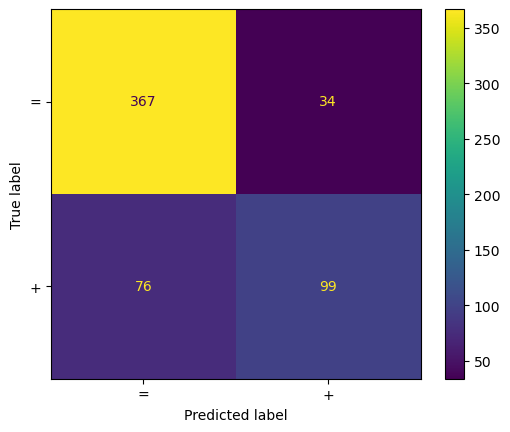

In [44]:
### CONFUSION MATRIX CV

estimator = tuners[1].best_estimator_
train_cls = train_clss[1]

pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv, display_labels=["=","+"])
plt.show()


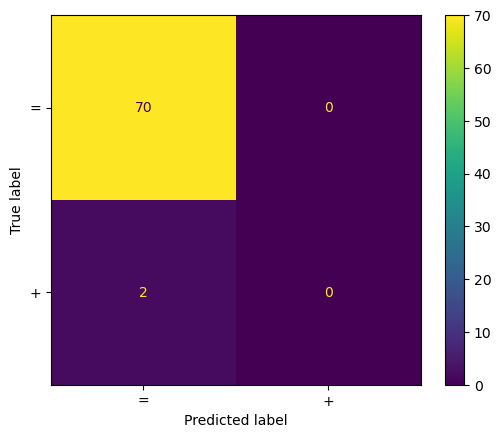

In [45]:
### CONFUSION MATRIX TEST

estimator = tuners[1].best_estimator_
test_cls = test_clss[1]

pred_arr_test = estimator.predict(test_cls.x)
y_pred_test = pd.Series(pred_arr_test, index=test_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(test_cls.y, y_pred_test, display_labels=["=","+"])
plt.show()


In [46]:
### FEATURE IMPORTANCE

features_names_out = estimator.steps[0][1].get_feature_names_out()
pd.Series(
    estimator.steps[-1][1].feature_importances_, index=features_names_out
).sort_values(ascending=False)



19_1                9.588e-02
unempl_5            9.456e-02
19_3                8.318e-02
unempl_6            8.006e-02
19_2                6.125e-02
unempl_3            5.985e-02
unempl_2            5.838e-02
19_4                5.365e-02
unempl_4            5.318e-02
19_6                4.995e-02
19_5                4.422e-02
gdp_4               4.418e-02
gdp_6               4.188e-02
gdp_3               4.134e-02
gdp_2               3.969e-02
gdp_5               3.741e-02
country_RO          1.686e-02
country_AT+CH       5.798e-03
country_IE          3.576e-03
country_HR          3.557e-03
country_HU          3.189e-03
country_IT          3.138e-03
country_GB          3.026e-03
country_BE+NL+LU    2.914e-03
country_SI          2.871e-03
country_GR          2.738e-03
country_BG          2.668e-03
country_FR          2.365e-03
country_LV+LT+EE    2.346e-03
country_CZ+SK       2.141e-03
country_PL          1.657e-03
country_SE+FI+DK    1.112e-03
country_PT          7.858e-04
country_ES

##### AR + macro

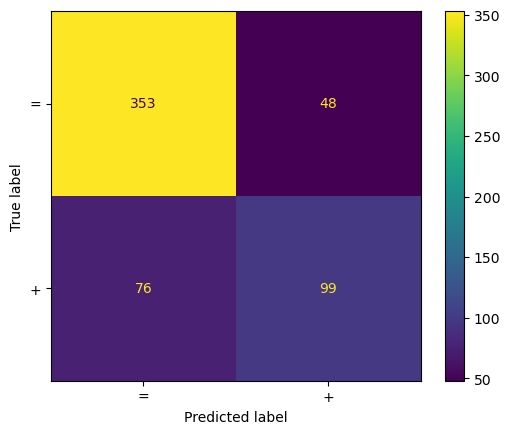

In [47]:
### CONFUSION MATRIX CV

estimator = tuners[-1].best_estimator_
train_cls = train_clss[-1]

pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv, display_labels=["=","+"])
plt.show()


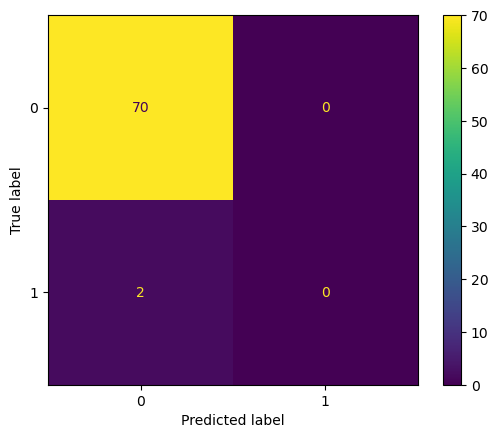

In [48]:
### CONFUSION MATRIX TEST

estimator = tuners[-1].best_estimator_
test_cls = test_clss[-1]

pred_arr_test = estimator.predict(test_cls.x)
y_pred_test = pd.Series(pred_arr_test, index=test_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(test_cls.y, y_pred_test)
plt.show()


##### All features

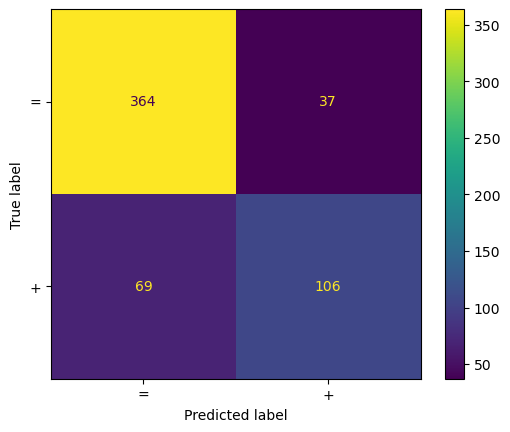

In [50]:
### CONFUSION MATRIX

# y predicted over cv
estimator = estimators[4]
train_cls = train_clss[4]

pred_arr_cv = model_selection.cross_val_predict(
    estimator, train_cls.x, train_cls.y, cv=cv_default
)
y_pred_cv = pd.Series(pred_arr_cv, index=train_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(train_cls.y, y_pred_cv, display_labels=["=","+"])
plt.show()


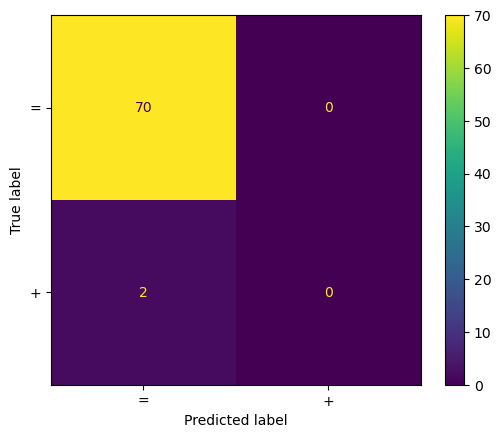

In [51]:
### CONFUSION MATRIX TEST

# y predicted over cv
estimator = estimators[4]
test_cls = test_clss[4]

pred_arr_test = estimator.predict(test_cls.x)
y_pred_test = pd.Series(pred_arr_test, index=test_cls.x.index)

metrics.ConfusionMatrixDisplay.from_predictions(test_cls.y, y_pred_test, display_labels=["=","+"])
plt.show()


In [42]:
### FEATURE IMPORTANCE

features_names_out = estimator.steps[0][1].get_feature_names_out()
pd.Series(
    estimator.steps[-1][1].feature_importances_, index=features_names_out
).sort_values(ascending=False)



value_2             1.733e-01
19_1                8.302e-02
value_3             8.065e-02
unempl_6            7.746e-02
unempl_5            6.579e-02
19_2                5.137e-02
unempl_3            4.911e-02
19_3                4.240e-02
unempl_2            4.008e-02
unempl_4            3.854e-02
gdp_6               3.477e-02
value_5             3.127e-02
19_6                2.750e-02
value_4             2.707e-02
19_5                2.699e-02
gdp_4               2.375e-02
gdp_5               2.148e-02
19_4                2.135e-02
gdp_2               2.110e-02
value_6             1.997e-02
gdp_3               1.834e-02
country_HR          4.282e-03
country_RO          2.834e-03
country_IT          2.542e-03
country_SI          1.374e-03
country_CZ+SK       1.333e-03
country_AT+CH       1.282e-03
country_GR          1.209e-03
country_BG          1.198e-03
country_LV+LT+EE    1.188e-03
country_IE          1.062e-03
country_HU          1.056e-03
country_FR          9.450e-04
country_GB

#### Accuracy by country

##### Compare by feature sets (CV only)

In [43]:
cv_scores = {}

for i, features in enumerate(feature_combinations):
    cv_scores_c = eumf_eval.score_cv_countries_cls(
        estimators[i],
        train_unstackeds[i],
        cv_default,
        BINS_TWOCLS,
        [0, 1],
        scoring=["accuracy"],
    )
    cv_scores[str(features)] = eumf_eval.agg_cv_scores(cv_scores_c, level=0)["accuracy", "mean"]

cv_scores = pd.concat(cv_scores, axis=1)

In [44]:
display(cv_scores)

,['dummy'],"['19', 'gdp', 'unempl']",['19'],"['gdp', 'unempl']","['value', '19', 'gdp', 'unempl']","['value', 'gdp', 'unempl']"
AT+CH,0.969,0.938,0.969,0.938,0.969,0.969
BE+NL+LU,1.000,0.969,1.000,0.875,1.000,1.000
BG,0.812,0.906,0.969,0.781,0.969,0.906
CZ+SK,0.844,0.844,0.875,0.906,0.875,0.844
ES,0.656,0.969,0.875,0.781,0.938,0.906
FR,1.000,1.000,1.000,0.938,1.000,1.000
GB,0.906,0.906,0.906,0.906,0.906,0.906
GR,0.750,0.812,0.938,0.750,0.812,0.781
HR,0.688,0.656,0.656,0.625,0.656,0.688
HU,0.781,0.812,0.844,0.781,0.844,0.781


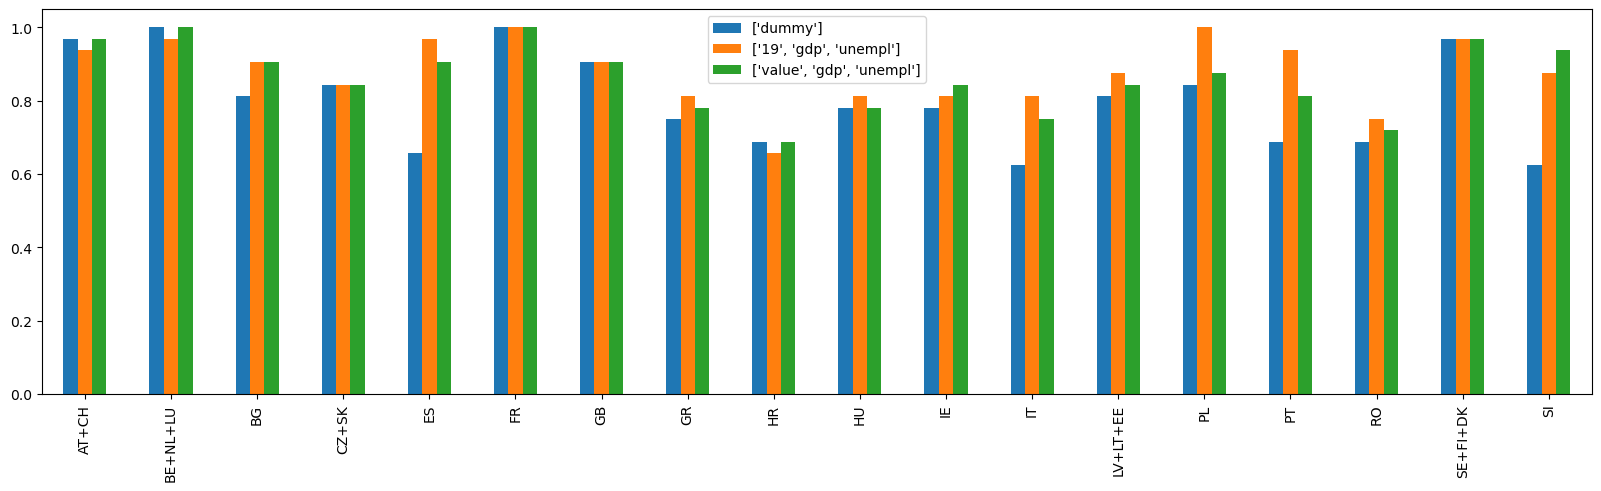

In [45]:
cv_scores.iloc[:,[0, 1, 5]].plot(kind="bar", figsize=(20, 5))
plt.show()

##### Highlighted configurations

Dummy

In [46]:
i = 0
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_clss[i], scoring=["accuracy"])
display(test_scores_c)

,accuracy
AT+CH,1.00
BE+NL+LU,1.00
BG,0.00
CZ+SK,0.75
ES,1.00
FR,1.00
GB,1.00
GR,1.00
HR,0.00
HU,1.00


In [47]:
i = 0
cv_scores_c = eumf_eval.score_cv_countries_cls(
    estimators[i],
    train_unstackeds[i],
    cv_default,
    BINS_TWOCLS,
    [0, 1],
    scoring=["accuracy"],
)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0)
display(cv_scores_c_agg.sort_values(by=("accuracy", "mean"), ascending=False))


CV scores per country:


accuracy              
           mean    std    sem  
FR         1.000   0.000  0.000
BE+NL+LU   1.000   0.000  0.000
AT+CH      0.969   0.088  0.031
SE+FI+DK   0.969   0.088  0.031
GB         0.906   0.129  0.046
CZ+SK      0.844   0.265  0.094
PL         0.844   0.352  0.124
BG         0.812   0.372  0.132
LV+LT+EE   0.812   0.347  0.123
IE         0.781   0.339  0.120
HU         0.781   0.411  0.145
GR         0.750   0.401  0.142
HR         0.688   0.347  0.123
PT         0.688   0.458  0.162
RO         0.688   0.458  0.162
ES         0.656   0.481  0.170
IT         0.625   0.518  0.183
SI         0.625   0.463  0.164

Trends + macro

In [48]:
i = 1
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_clss[i], scoring=["accuracy"])
display(test_scores_c)

,accuracy
AT+CH,1.00
BE+NL+LU,1.00
BG,0.00
CZ+SK,0.75
ES,1.00
FR,1.00
GB,1.00
GR,0.75
HR,1.00
HU,1.00


In [49]:
i = 1
cv_scores_c = eumf_eval.score_cv_countries_cls(
    estimators[i],
    train_unstackeds[i],
    cv_default,
    BINS_TWOCLS,
    [0, 1],
    scoring=["accuracy"],
)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0)
display(cv_scores_c_agg.sort_values(by=("accuracy", "mean"), ascending=False))


CV scores per country:


accuracy              
           mean    std    sem  
FR         1.000   0.000  0.000
PL         1.000   0.000  0.000
SE+FI+DK   0.969   0.088  0.031
ES         0.969   0.088  0.031
BE+NL+LU   0.969   0.088  0.031
AT+CH      0.938   0.116  0.041
PT         0.938   0.177  0.062
BG         0.906   0.129  0.046
GB         0.906   0.129  0.046
LV+LT+EE   0.875   0.189  0.067
SI         0.875   0.267  0.094
CZ+SK      0.844   0.265  0.094
IT         0.812   0.372  0.132
IE         0.812   0.259  0.091
GR         0.812   0.347  0.123
HU         0.812   0.372  0.132
RO         0.750   0.378  0.134
HR         0.656   0.352  0.124

All features

In [50]:
i = 4
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_clss[i], scoring=["accuracy"])
display(test_scores_c)

,accuracy
AT+CH,1.00
BE+NL+LU,1.00
BG,0.00
CZ+SK,0.75
ES,0.75
FR,1.00
GB,1.00
GR,1.00
HR,1.00
HU,1.00


In [51]:
i = 4
cv_scores_c = eumf_eval.score_cv_countries_cls(
    estimators[i],
    train_unstackeds[i],
    cv_default,
    BINS_TWOCLS,
    [0, 1],
    scoring=["accuracy"],
)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0)
display(cv_scores_c_agg.sort_values(by=("accuracy", "mean"), ascending=False))


CV scores per country:


accuracy              
           mean    std    sem  
FR         1.000   0.000  0.000
BE+NL+LU   1.000   0.000  0.000
AT+CH      0.969   0.088  0.031
BG         0.969   0.088  0.031
SE+FI+DK   0.969   0.088  0.031
ES         0.938   0.116  0.041
GB         0.906   0.129  0.046
LV+LT+EE   0.875   0.267  0.094
PT         0.875   0.231  0.082
PL         0.875   0.267  0.094
SI         0.875   0.267  0.094
IE         0.875   0.134  0.047
CZ+SK      0.875   0.267  0.094
HU         0.844   0.352  0.124
IT         0.812   0.347  0.123
GR         0.812   0.347  0.123
RO         0.750   0.354  0.125
HR         0.656   0.297  0.105

In [52]:
pd.concat({"bla":cv_scores_c_agg["accuracy", "mean"], "blubb":cv_scores_c_agg["accuracy", "mean"]}, axis=1)

,bla,blubb
AT+CH,0.969,0.969
BE+NL+LU,1.000,1.000
BG,0.969,0.969
CZ+SK,0.875,0.875
ES,0.938,0.938
FR,1.000,1.000
GB,0.906,0.906
GR,0.812,0.812
HR,0.656,0.656
HU,0.844,0.844
